In [50]:
from mobo.surrogate_model import BoTorchSurrogateModelReapeat, BoTorchSurrogateModel
from mobo.transformation import StandardTransform
import numpy as np

In [51]:
import torch
import pandas as pd
from pathlib import Path

sm = BoTorchSurrogateModelReapeat(n_var=4, n_obj=3, alpha=0.9, n_w=11)

# .\result\exp4d\optimization_4\marsdet\0\state_dict_noise.pt

path = Path("./result/exp4d/optimization_4/marsdet/0/")

state_dict = torch.load(path / "state_dict.pt")
state_dict_noise = torch.load(path / "state_dict_noise.pt")

eval_samples = pd.read_csv(path / "EvaluatedSamples.csv")
eval_samples.columns.to_list()


# train_X = eval_samples[["x1", "x2", "x3", "x4"]].values
# use pandas filter to select columns
train_X = eval_samples.filter(regex="^x[0-9]").values
train_Y = eval_samples.filter(regex="^f[0-9]").values
train_Yvar = eval_samples.filter(regex="^rho_f[0-9]").values

import torch
#np to torch
train_X = torch.tensor(train_X, dtype=torch.float)
train_Y = -torch.tensor(train_Y, dtype=torch.float)
train_Yvar = torch.tensor(train_Yvar, dtype=torch.float)

# botorch cross validation
from botorch import cross_validation
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.cross_validation import batch_cross_validation, gen_loo_cv_folds
cv_folds = gen_loo_cv_folds(train_X, train_Y, train_Yvar)
cv_results = batch_cross_validation(
    SingleTaskGP,
    ExactMarginalLogLikelihood,
    cv_folds,
)
cv_results



CVResults(model=SingleTaskGP(
  (likelihood): FixedNoiseGaussianLikelihood(
    (noise_covar): FixedGaussianNoise()
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): MaternKernel(
      (lengthscale_prior): GammaPrior()
      (raw_lengthscale_constraint): Positive()
    )
    (outputscale_prior): GammaPrior()
    (raw_outputscale_constraint): Positive()
  )
), posterior=<botorch.posteriors.gpytorch.GPyTorchPosterior object at 0x000001478E551610>, observed_Y=tensor([[[ 0.2301,  3.4733,  0.9930]],

        [[ 0.9098,  2.2933,  6.0390]],

        [[ 0.0455,  0.7600,  2.3805]],

        [[ 0.9325,  2.3733,  4.0239]],

        [[ 0.0301,  1.1633,  2.0240]],

        [[ 0.9388,  2.2800,  4.7802]],

        [[ 0.0433,  1.1833,  3.8102]],

        [[ 0.1373,  3.9300,  0.5810]],

        [[ 0.0827,  4.1900,  0.4130]],

        [[ 0.9369,  2.3600,  4.6739]],

        [[ 0.9380,  2.5100,  9.7902]],

        [[ 0.8870,  2.6833,  1.9032]],

        [[ 0.9185,  2.

In [52]:
# # Toy example
# train_X = torch.rand(30, 2)
# train_Y = torch.sin(6 * train_X) + 0.2 * torch.rand_like(train_X)
# # 2d

# cv_folds = gen_loo_cv_folds(train_X, train_Y)
# cv_results = batch_cross_validation(
#     SingleTaskGP,
#     ExactMarginalLogLikelihood,
#     cv_folds,
# )
# pred_posterior = cv_results.posterior
# pred_Y = pred_posterior.mean.squeeze()
# pred_Yvar = pred_posterior.variance.squeeze()

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'bright', 'cjk-jp-font', 'cjk-kr-font', 'cjk-sc-font', 'cjk-tc-font', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'grid', 'high-contrast', 'high-vis', 'ieee', 'latex-sans', 'light', 'muted', 'nature', 'no-latex', 'notebook', 'pgf', 'retro', 'sans', 'scatter', 'science', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'std-colors', 'tableau-colorblind10', 'vibrant']


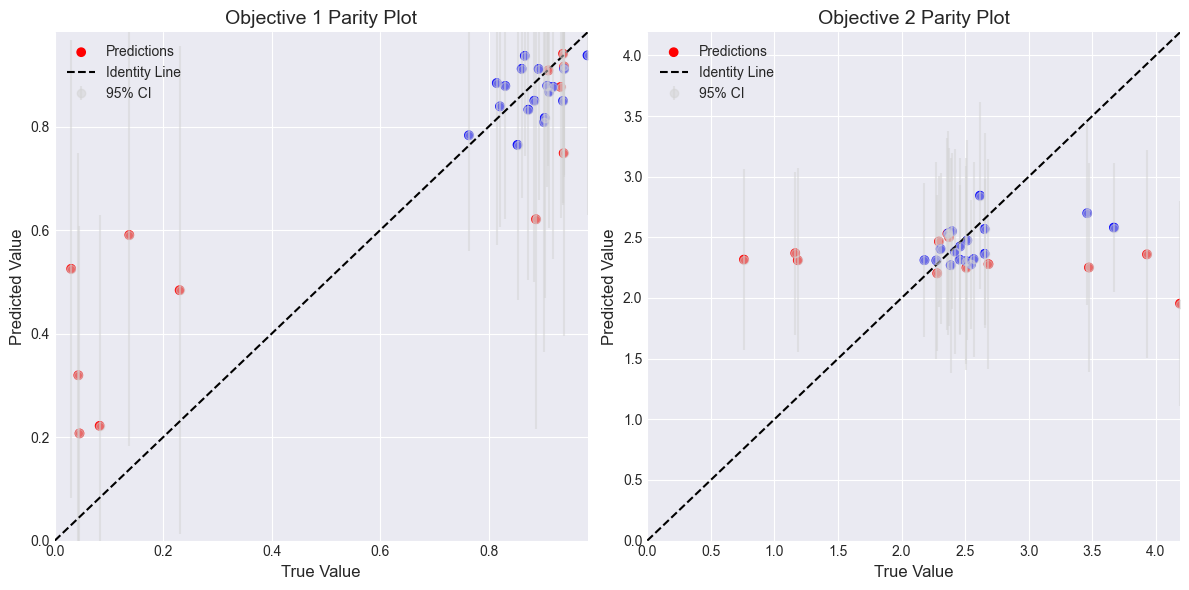

Mean Absolute Error for each objective: [0.10769342 0.47514457 0.5089382 ]


In [53]:
# train_Y = cv_results.observed_Y.squeeze()
# train_Yvar = cv_results.observed_Yvar.squeeze()
pred_posterior = cv_results.posterior
pred_Y = pred_posterior.mean.squeeze()
pred_Yvar = pred_posterior.variance.squeeze()


import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn

# Assuming pred_Y, pred_Yvar, and train_Y are already defined as shown in your snippet
# Calculate standard deviation for confidence intervals
pred_Ystd = torch.sqrt(pred_Yvar)

# Prepare the plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

print(plt.style.available)  # List available styles
plt.style.use('vibrant') # Use a nice style for scientific plots

# bool array for sobol experiments vs optimization
sobol = np.array([i < 12 for i in range(len(train_Y))])

# Colors: 'red' for Sobol, 'blue' for others
colors = np.where(sobol, 'red', 'blue')  # Use 'red' for True (Sobol), 'blue' for False (others)


for i in range(len(train_Y[0])-1):
    
    # Error bars for confidence intervals
    ax[i].errorbar(train_Y[:, i], pred_Y[:, i], yerr=1.96 * pred_Ystd[:, i], fmt='o', color="lightgray", alpha=0.5, label="95% CI")
    
    # Scatter plot for predictions vs. true values
    ax[i].scatter(train_Y[:, i], pred_Y[:, i], label="Predictions", alpha=1., c=colors)
    
    # Identity line
    max_val = max(max(train_Y[:, i]), max(pred_Y[:, i]))
    ax[i].plot([0, max_val], [0, max_val], "k--", label="Identity Line")
    
    # Set limits for better comparison
    ax[i].set_xlim([0, max_val])
    ax[i].set_ylim([0, max_val])
    
    # Enhance labeling
    ax[i].set_xlabel("True Value", fontsize=12)
    ax[i].set_ylabel("Predicted Value", fontsize=12)
    ax[i].set_title(f"Objective {i+1} Parity Plot", fontsize=14)
    ax[i].legend()

plt.tight_layout()
plt.show()

# Calculate and print MAE for each objective
mae = torch.mean(torch.abs(pred_Y - train_Y), dim=0)
print("Mean Absolute Error for each objective:", mae.numpy())
